In [8]:
from desc.compute.utils import get_transforms, get_profiles, get_params
from desc.compute import compute as compute_fun
from desc.backend import jnp
from desc.grid import Grid, LinearGrid
import desc.io
import desc.examples
from functools import partial
from jax import jit
from jax.experimental.ode import odeint as jax_odeint
import matplotlib.pyplot as plt
import numpy as np
import time

eq = desc.io.load("test_run.h5")
eq._iota = eq.get_profile("iota")
eq._current = None

"""
#plot_3d(eq, "|B|")
# a = [energy, const1, const2, const3, B_ref]
#normalizar o tempo: t_tilde = t*omega
#normalizar o psi: psi_tilde = b_ref*(L^2) L tamanho a definir (Raio de Larmor) 
#normalizar a velocidade - v_tilde = v/(L*omega) //// v_tidle = v/sqrt(2E/m)
#omega = q*B_ref/m
B_tilde = data["B"]/B_ref
B_abs_tilde = data["|B|"]/B_ref
grad_B_tilde = data["grad(|B|)"]/B_ref 
"""

def B_for_f_ratio_surface(psi_i, theta_i, zeta_i):
    grid = LinearGrid(rho = np.sqrt(0.25), M = 20, N = 20, NFP = eq.NFP)
    output = eq.compute("|B|", grid=grid)
    B = output["|B|"]
    print(B)
    return B

def B_for_f_ratio_fieldline():
    coords = jnp.ones((250, 3)) #rho alpha zeta
    coords = coords.at[:, 0].set(coords[:, 0] * jnp.sqrt(0.25))
    coords = coords.at[:, 2].set(jnp.linspace(0, 6 * jnp.pi, 250))

    start_time = time.time()
    print("starting map coords")
    print("--- %s seconds ---" % (time.time() - start_time))

    coords1 = eq.map_coordinates(
        coords=coords,
        inbasis=["rho", "alpha", "zeta"],
        outbasis=["rho", "theta", "zeta"],
        period=[jnp.inf, 2 * jnp.pi, jnp.inf],
        guess=None,
    )  # (2 * jnp.pi / eq.NFP)],

    grid = Grid(coords1, jitable=False, sort=False)
    output = eq.compute("|B|", grid=grid)

    #grid = LinearGrid(rho = np.sqrt(0.25), M = 20, N = 20, NFP = eq.NFP)
    B = output["|B|"]
    return B, coords1

def f_ratio(B):
    return np.sqrt(1-np.nanmin(B)/np.nanmax(B))

B, coords1 = B_for_f_ratio_fieldline()

f = f_ratio(B)
min_index = np.nanargmin(B)

starting map coords
--- 0.0015642642974853516 seconds ---


In [9]:
def rhs(w, t, a):
    #initial conditions
    psi, theta, zeta, vpar = w
    
    keys = ["B", "|B|", "grad(|B|)", "grad(psi)", "e^theta", "e^zeta", "G"] # etc etc, whatever terms you need
    grid = Grid(jnp.array([psi, theta, zeta]).T, jitable=True, sort=False)
    transforms = get_transforms(keys, eq, grid, jitable=True)
    profiles = get_profiles(keys, eq, grid, jitable=True)
    params = get_params(keys, eq)
    data = compute_fun(eq, keys, params, transforms, profiles)
    
    E, m_q = a
    m = m_q*1.6e-19

    b = (data["B"]/data["|B|"]) 
    mu = E/(m*data["|B|"]) - (vpar**2)/(2*data["|B|"])
    
    psidot = m_q*(1/data["|B|"]**3)*(mu*data["|B|"] + vpar**2) * jnp.sum(jnp.cross(data["B"], data["grad(|B|)"], axis = -1) * data["grad(psi)"])    
    thetadot = (vpar/data["|B|"]) * jnp.sum(data["B"] * data["e^theta"]) + m_q*(1/data["|B|"]**3)*(mu*data["|B|"] + vpar**2)*jnp.sum(jnp.cross(data["B"], data["grad(|B|)"], axis=-1) * data["e^theta"])
    zetadot = (vpar/data["|B|"]) * jnp.sum(data["B"]* data["e^zeta"]) 
    vpardot = -mu*jnp.sum(b * data["grad(|B|)"])    
    
    return jnp.array([psidot, thetadot, zetadot, vpardot])

In [10]:
def run(E_, q_, m_, t_i, t_f, nt_ ,psi_i, theta_i, zeta_i, vpar_i_ratio):
    e_charge = q_*1.6e-19
    m = m_*1.673e-27
    tmin = t_i
    tmax = t_f
    nt = nt_
    E = E_*3.52e6*e_charge
    m_q = m/e_charge

    v_parallel = vpar_i_ratio*jnp.sqrt(2*E/m)
    a_initial = [E, m_q]
    initial_conditions = [psi_i, theta_i, zeta_i, v_parallel] #

    def solve_with_jax(a=None):
        initial_conditions_jax = jnp.array(initial_conditions, dtype=jnp.float64)
        a_jax = jnp.array(a_initial, dtype=jnp.float64)
        t_jax = jnp.linspace(tmin, tmax, nt)
        system_jit = jit(rhs)
        solution_jax = jax_odeint(partial(system_jit, a=a_jax), initial_conditions_jax, t_jax)
        return solution_jax
    
    sol = solve_with_jax()
    print(sol)

    return sol

In [13]:
E_ = 1
q_= 1
m_ = 1
t_i = 0 
t_f = 1e-5
nt_ = 150

psi_i = coords1[min_index, 0]**2
theta_i = coords1[min_index, 1]
zeta_i = coords1[min_index, 2]

#psi_i = 0.7
#theta_i = 1.2
#zeta_i = 0.1

B_ = B_for_f_ratio_surface(psi_i=psi_i, theta_i=theta_i, zeta_i=zeta_i)
f = f_ratio(B_)

print(psi_i, theta_i, zeta_i)

vpar_i_ratio = 0.99
print(vpar_i_ratio)
sol = run(E_, q_, m_, t_i, t_f, nt_, psi_i, theta_i, zeta_i, vpar_i_ratio)

[5.13088276 5.13296511 5.13914997 ... 5.14696322 5.13733047 5.13173602]
0.25 -0.03976132529636434 12.414968558764482
0.99


2023-09-01 10:57:58.213791: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m32.794183031s

********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


[[ 2.50000000e-01 -3.97613253e-02  1.24149686e+01  2.56881924e+07]
 [ 2.49798447e-01  1.56278259e-02  1.25014187e+01  2.56881915e+07]
 [ 2.49338321e-01  7.66764630e-02  1.25874924e+01  2.56881811e+07]
 [ 2.48700804e-01  1.35590515e-01  1.26737190e+01  2.56881700e+07]
 [ 2.47682790e-01  1.85945217e-01  1.27606280e+01  2.56881160e+07]
 [ 2.46260541e-01  2.25655235e-01  1.28487463e+01  2.56880711e+07]
 [ 2.44639023e-01  2.56213415e-01  1.29386031e+01  2.56880713e+07]
 [ 2.42820978e-01  2.80483857e-01  1.30307245e+01  2.56880317e+07]
 [ 2.40619930e-01  3.01480726e-01  1.31256147e+01  2.56879416e+07]
 [ 2.38088575e-01  3.22144940e-01  1.32237387e+01  2.56878947e+07]
 [ 2.35424798e-01  3.44177611e-01  1.33255021e+01  2.56878695e+07]
 [ 2.32520492e-01  3.65653145e-01  1.34312029e+01  2.56877868e+07]
 [ 2.29270039e-01  3.82913841e-01  1.35409709e+01  2.56876940e+07]
 [ 2.25915247e-01  4.00797862e-01  1.36547321e+01  2.56876653e+07]
 [ 2.22416039e-01  4.35000233e-01  1.37721623e+01  2.56875746e

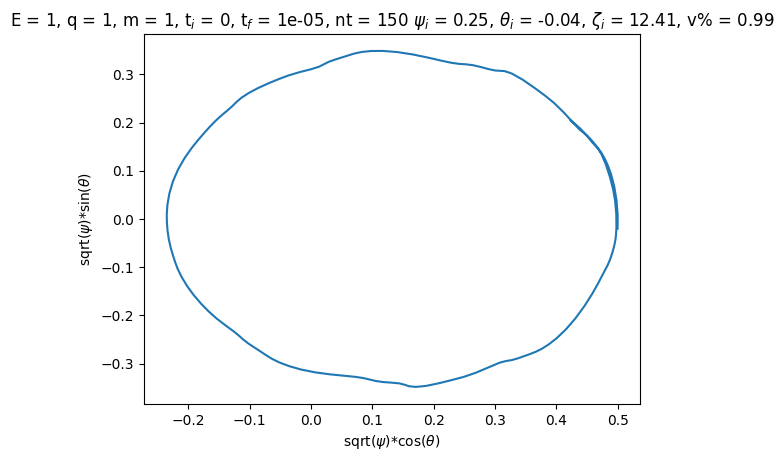

In [14]:
plt.plot(np.sqrt(sol[:, 0]) * np.cos(sol[:, 1]), np.sqrt(sol[:, 0]) * np.sin(sol[:, 1]))
plt.xlabel(r'sqrt($\psi$)*cos($\theta$)')
plt.ylabel(r'sqrt($\psi$)*sin($\theta$)')
plt.title(rf'E = {E_}, q = {q_}, m = {m_}, t$_i$ = {t_i}, t$_f$ = {t_f}, nt = {nt_} $\psi_i$ = {psi_i:.2f}, $\theta_i$ = {theta_i:.2f}, $\zeta_i$ = {zeta_i:.2f}, v% = {vpar_i_ratio:.2f}')
plt.show()

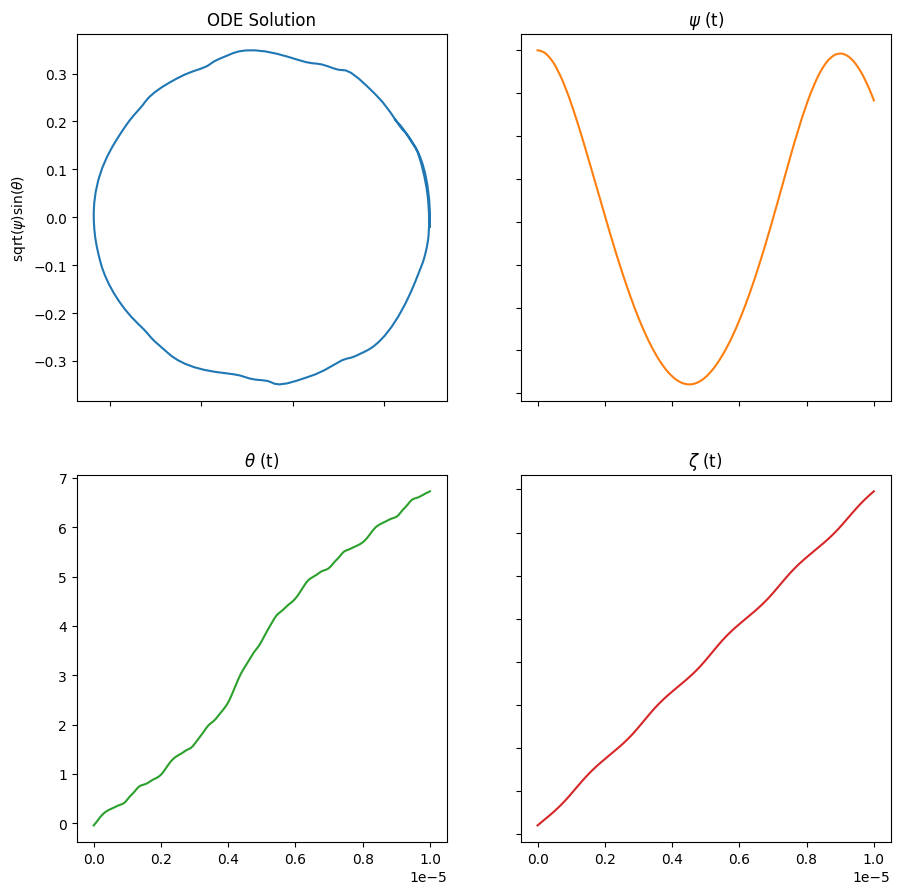

In [37]:
t = np.linspace(t_i, t_f, nt_)
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(np.sqrt(sol[:, 0]) * np.cos(sol[:, 1]), np.sqrt(sol[:, 0]) * np.sin(sol[:, 1]))
axs[0, 0].set_title("ODE Solution")
axs[0, 0].set(xlabel='x-label', ylabel=r'sqrt($\psi$)sin($\theta$)')

axs[0, 1].plot(t, sol[:, 0], 'tab:orange')
axs[0, 1].set_title(r'$\psi$ (t)')


axs[1, 0].plot(t, sol[:, 1], 'tab:green')
axs[1, 0].set_title(r'$\theta$ (t)')
axs[1, 1].plot(t, sol[:, 2], 'tab:red')
axs[1, 1].set_title(r'$\zeta$ (t)')


for ax in axs.flat:
    ax.label_outer()

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
fig.savefig('fullsolution.png', dpi=100)